In [1]:
# Import packages
import numpy as np
from skimage.segmentation import slic
from skimage.transform import resize
from skimage.filters import gaussian
from PIL import Image
import matplotlib.pyplot as plt

# Import samplers
from post_hoc.samplers import RandomSampler, SingleFeatureSampler, ShapSampler
# Import explainers
from post_hoc.explainers import OriginalCIUAttributer, SHAPAttributer, RISEAttributer
# Import segmenters
from post_hoc.image_segmenters import GridSegmenter, WrapperSegmenter, FadeMaskSegmenter
# Import image perturbers
from post_hoc.image_perturbers import SingleColorPerturber, ReplaceImagePerturber, TransformPerturber
# Import connectors
from post_hoc.connectors import SegmentationAttribuitionPipeline
# Import image explanation visualizers
from post_hoc.image_visualizers import TopVisualizer, HeatmapVisualizer, AUCVisualizer
# Import PyTorch utils
from post_hoc.torch_utils import TorchModelWrapper, ImageToTorch
# Import explanation evaluators
from post_hoc.evaluation import ImageAUCEvaluator

# Set seed for reproducibility (due to random noise used later)
np.random.seed(6)

In [2]:
# Collecting the image and resizing to fit later model input
img = resize(np.array(Image.open('images/LabradorPlayingGuitar.jpg')), (224,224,3))

# Create the segmenters, samplers, perturbers, and explainers
grid_segmenter = GridSegmenter(10, 10, bilinear=False)
slic_segmenter = WrapperSegmenter(slic, n_segments=50, compactness=10, start_label=0)
fade_grid_segmenter = FadeMaskSegmenter(grid_segmenter, sigma=7)

shap_sampler = ShapSampler()
ciu_sampler  = SingleFeatureSampler(add_none=True)
rise_sampler = RandomSampler()

gray_perturbation = SingleColorPerturber(np.array((0.5,0.5,0.5)))
blur_perturbation = TransformPerturber(gaussian, sigma=10)
rand_img = np.random.rand(*img.shape) # Create a random noisy image to replace masked pixels with
noise_perturbation = ReplaceImagePerturber(rand_img)

shap_values = SHAPAttributer()
original_ciu_values = OriginalCIUAttributer()
rise_values = RISEAttributer()

In [3]:
# Create the three attribution pipelines
# The explainers are wrapped in lists as the pipelines can use multiple explainers
# We set per_pixel to make the pipelines also return per pixel attribution maps
slic_gray_shap_pipeline = SegmentationAttribuitionPipeline(
    segmenter=slic_segmenter, sampler=shap_sampler,
    perturber=gray_perturbation, explainers=[shap_values], per_pixel=True, batch_size=50
)
grid_blur_ciu_pipeline = SegmentationAttribuitionPipeline(
    segmenter=grid_segmenter, sampler=ciu_sampler,
    perturber=blur_perturbation, explainers=[original_ciu_values], per_pixel=True, batch_size=50
)
grid_noise_rise_pipeline = SegmentationAttribuitionPipeline(
    segmenter=fade_grid_segmenter, sampler=rise_sampler,
    perturber=noise_perturbation, explainers=[rise_values], per_pixel=True, batch_size=50
)

In [4]:
# Import Torchvision which will be used for inference
import torchvision
import torchvision.transforms as v1

# Collect an ImageNet pretrained AlexNet model to predict image classes
alexnet = torchvision.models.alexnet(weights='IMAGENET1K_V1')
alexnet.eval()

# Create a transform to prepare images for AlexNet
transforms = v1.Compose([
    ImageToTorch(),
    v1.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v1.Resize((224,224), antialias=True)
])

# The ImageNet indexes for labrador and acoustic guitar
labrador = 208
guitar = 402

# Create a model using the modelwrapper
# The output_idxs indicate which classes to return and will be explained
model = TorchModelWrapper(alexnet, transforms, output_idxs=((labrador,guitar)))

In [5]:
# Compute attribution using each pipeline
# Each pipeline return two list of lists with the explanations and pixel maps
# These pipelines only have one explainer at index 0 of the outer lists
# The explanations and pixel maps for the classes are at indices 0 and 1 of the inner lists

# Calculate SHAP values for each segment
shap, shap_pixels = slic_gray_shap_pipeline(img, model, sample_size=68)
lab_shap_base, lab_shaps, slic_feature_idx = shap[0][0]
gui_shap_base, gui_shaps, slic_feature_idx = shap[0][1]
lab_shap_pixels, gui_shap_pixels = shap_pixels[0]

# Calculate CIU values for each segment
ciu, ciu_pixels = grid_blur_ciu_pipeline(img, model)
lab_ci, lab_cu, lab_infl, grid_feature_idx = ciu[0][0]
gui_ci, gui_cu, gui_infl, grid_feature_idx = ciu[0][1]
lab_ciu_pixels, gui_ciu_pixels = ciu_pixels[0]

# Calculate the RISE values for each segment
rise, rise_pixels = grid_noise_rise_pipeline(img, model, sample_size=100)
(lab_rise, grid_feature_idx), (gui_rise, grid_feature_idx) = rise[0]
lab_rise_pixels, gui_rise_pixels = rise_pixels[0]


/home/guspih/Repositories/post-hoc-image-pertubations/post_hoc/explainers.py:421: RuntimeWarning: divide by zero encountered in divide
  (M - 1) / (scipy.special.binom(M, S_vals) * S_vals * (M - S_vals)),


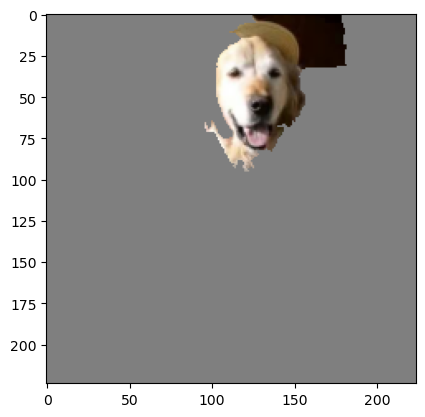

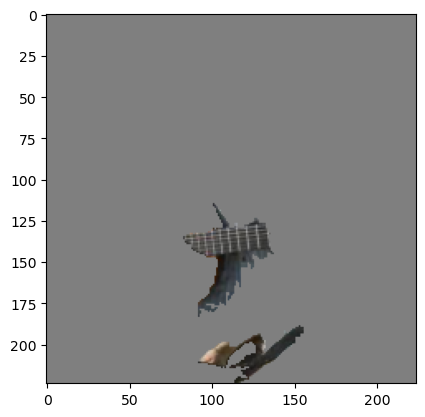

In [6]:
# Attribution by SLIC+shap_sampler+single_color_perturbation+SHAP

# Using TopVisualizer to find the 2 segments with the highest attribution score for labrador and guitar
# The other segments are then removed, showing only the top 2
top2_visualizer = TopVisualizer(k=2, perturber=gray_perturbation)
lab_shap_visual = top2_visualizer(lab_shaps, img, slic_gray_shap_pipeline.masks)
gui_shap_visual = top2_visualizer(gui_shaps, img, slic_gray_shap_pipeline.masks)

# Display the 2 segments with the higest attribution scores
plt.figure()
plt.imshow(lab_shap_visual)
plt.figure()
plt.imshow(gui_shap_visual)

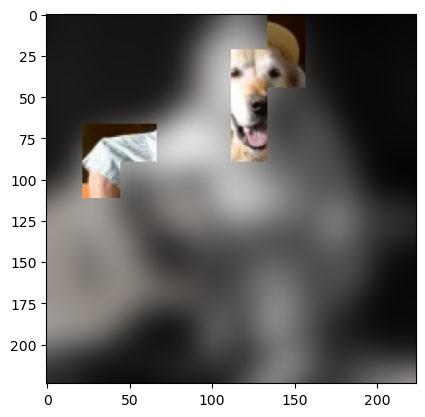

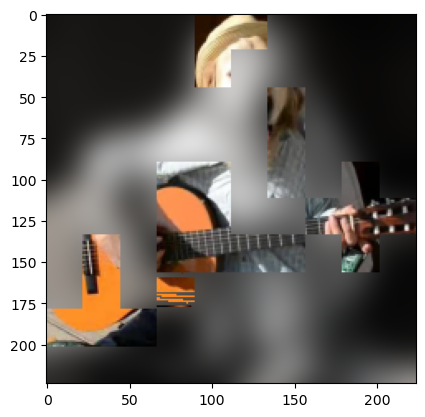

In [7]:
# Attribution by grid+naive_ciu_sampler+blur perturbation+CIU

# Using TopVisualizer to visualize segments such that their combined attribution score is at least 30% of the total
top10percent_visualizer = TopVisualizer(p=0.3, perturber=blur_perturbation)
lab_ciu_visual = top10percent_visualizer(lab_infl, img, grid_blur_ciu_pipeline.masks)

# This can also be performed on the pixel map of attribution
# Notice that a few pixels are missing from one segment as they are not needed to get 30% of the attribution
gui_ciu_visual = top10percent_visualizer(gui_ciu_pixels, img)

# Display the fewest segements that holds at least 30% of the attribution score
plt.figure()
plt.imshow(lab_ciu_visual)
plt.figure()
plt.imshow(gui_ciu_visual)

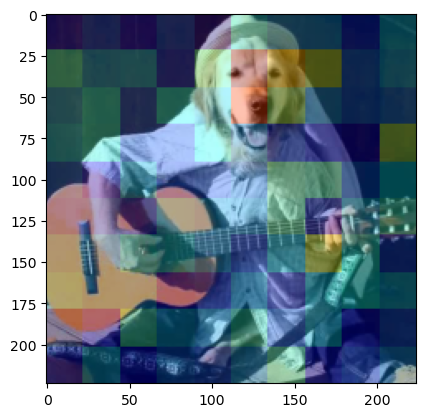

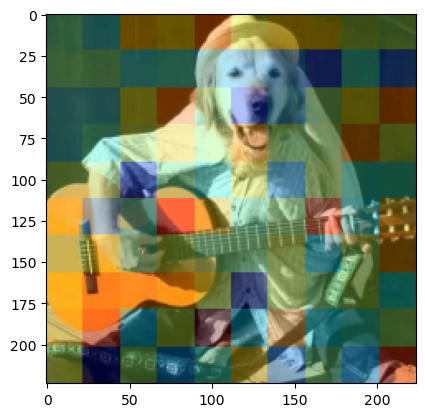

In [8]:
# Attribution by faded grid+random_sampler+noisy perturbation+RISE

# Using HeatmapVisualizer to create a heatmap of the attribution score per segment
# The heatmap is then overlaid the original image to show the strength of attribution
heatmap_visualizer = HeatmapVisualizer(normalize=True, image_weight=0.7, invert_colormap=True)
lab_rise_visual = heatmap_visualizer(lab_rise, img, grid_noise_rise_pipeline.masks)
gui_rise_visual = heatmap_visualizer(gui_rise, img, grid_noise_rise_pipeline.masks)

# Display a heatmap of the segment attribution overlaid the original image
plt.figure()
plt.imshow(lab_rise_visual)
plt.figure()
plt.imshow(gui_rise_visual)

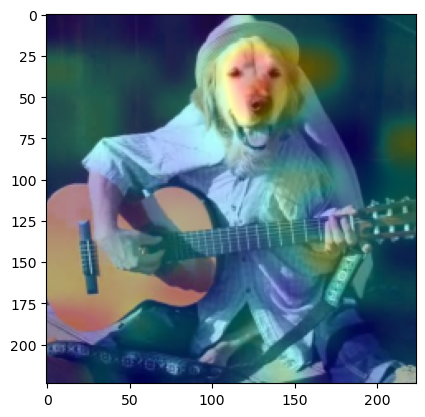

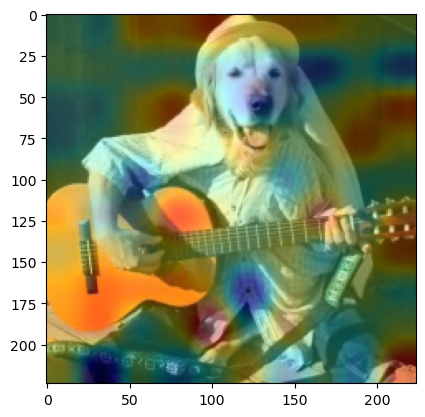

In [9]:
# Pixel attribution by faded grid+random_sampler+noisy perturbation+RISE

# Since the RISE pipeline uses masks with gradients between 0 and 1 each pixel can be attributed individually
# This is done by assigning each pixel the attribution of each mask that overlaps it weighed by the mask value for that pixel
# This process works for any set of overlapping or gradient masks, but for RISE explanations it is equivalent to RISE attribution per pixel
lab_rise_pixels_visual = heatmap_visualizer(lab_rise, img, grid_noise_rise_pipeline.transformed_masks)

# This can also be done by directly visualizing the attribution map per pixels without using masks
gui_rise_pixels_visual = heatmap_visualizer(gui_rise_pixels, img)

# Display a heatmap of pixel attribution overlaid the original image
plt.figure()
plt.imshow(lab_rise_pixels_visual)
plt.figure()
plt.imshow(gui_rise_pixels_visual)

Attribution pipeline:				 SRG Score (LIF-MIF):
SLIC+shap_sampler+gray_perturbation+SHAP	 0.8148557
grid+naive_ciu_sampler+blur_perturbation+CIU	 0.66541743
grid+random_sampler+noise_perturbation+RISE	 0.74419373


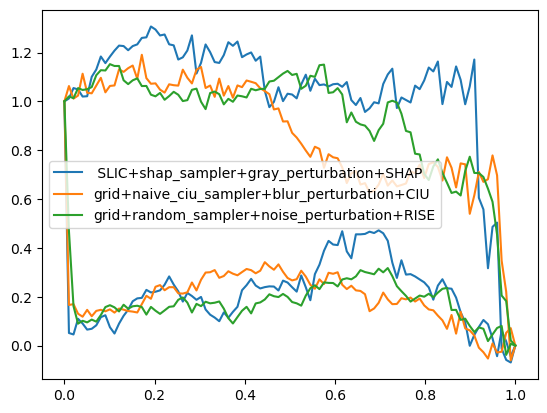

In [10]:
# Calculate the LIF and MIF scores (AUC) of the explainations
# This is done by steadily deleting more of the image starting with the least/most attributed pixels (LIF/MIF).
# For LIF a better score is higher since it indicates that the impactful areas were deleted last
# The opposite goes for MIF, with lower scores indicating that the most impactful was deleted first
# The LIF and MIF scores are equivalent to the insertion and deletion scores except the insertion curve is reversed

srg_evaluator = ImageAUCEvaluator(return_curves=True, normalize=True, return_visuals=True)
lab_shap_scores, lab_shap_curves, shap_visuals = srg_evaluator(img, model, lab_shap_pixels, model_idxs=(...,0), sample_size=100)
lab_ciu_scores, lab_ciu_curves, ciu_visuals = srg_evaluator(img, model, lab_ciu_pixels, model_idxs=(...,0), sample_size=100)
lab_rise_scores, lab_rise_curves, rise_visuals = srg_evaluator(img, model, lab_rise_pixels, model_idxs=(...,0), sample_size=100)

# Print the SRG scores (insertion AUC - deletion AUC):
print('Attribution pipeline:\t\t\t\t SRG Score (LIF-MIF):')
print('SLIC+shap_sampler+gray_perturbation+SHAP\t', lab_shap_scores[-1][0])
print('grid+naive_ciu_sampler+blur_perturbation+CIU\t', lab_ciu_scores[-1][0])
print('grid+random_sampler+noise_perturbation+RISE\t', lab_rise_scores[-1][0])

# Plot the LIF/MIF curves showing the prediction vs. the fraction of the image deleted
viz = AUCVisualizer()
viz(
    (lab_shap_curves,' SLIC+shap_sampler+gray_perturbation+SHAP'),
    (lab_ciu_curves, 'grid+naive_ciu_sampler+blur_perturbation+CIU'),
    (lab_rise_curves, 'grid+random_sampler+noise_perturbation+RISE')
)
